In [ ]:
# include("../finite_difference.jl")
# include("../ode_solver.jl")

# kappa = 1   # diffusion constant
# L = 1.0         # length of spatial domain
# T = 0.5         # total time to solve for

# function u_I(x)
#     # initial temperature distribution
#     y = sin.(pi*x/L)
#     return y
# end

# function u_exact(x,t)
#     # the exact solution
#     y = exp.(-kappa*(pi^2/L^2)*t)*sin.(pi*x/L)
#     return y
# end

# # Set numerical parameters
# mx = 10     # number of gridpoints in space
# mt = 1000   # number of gridpoints in time


# # forward euler Estimate
# weird_x, u_j = finite_difference(u_I, kappa, L, T, mx, mt, forward_euler)
# # Create trace
# f_euler = scatter(x=x, y=u_j, mode="markers", name="forward euler", showlegend=true)


# # backward euler Estimate
# x, u_j = finite_difference(u_I, kappa, L, T, mx, mt, backward_euler)
# # Create trace
# b_euler = scatter(x=x, y=u_j, mode="markers", name="backward euler", showlegend=true)


# # crank nicholson Estimate
# x, u_j = finite_difference(u_I, kappa, L, T, mx, mt, crank_nicholson)
# # Create trace
# c_nicholson = scatter(x=x, y=u_j, mode="markers", name="crank nicholson", showlegend=true)



# # Plot the final result and exact solution
# xx = LinRange(0,L,250)

# # Create solution trace
# exact = scatter(x=xx, y=u_exact(xx,T), mode="lines", name="exact", showlegend=true)

# layout = Layout(
#     xaxis_title = "x",
#     yaxis_title = "u(x,0.5)"
#     )

# plot([exact, f_euler, b_euler, c_nicholson], layout)

In [1]:
using PlotlyJS
using Test
include("../ode_solver.jl")
include("../numerical_continuation.jl")
include("../numerical_shooting.jl")
include("../examples/example_functions.jl")
include("../visualisation.jl")
include("../finite_difference.jl")

crank_nicholson (generic function with 1 method)

In [62]:

test = ProgressUnknown("Performing tests: ", spinner=true)

@testset verbose = true "System Unit Tests" begin

    @testset verbose = true "ode_solver" begin

        @testset verbose = true "Input Tests" begin

            # test error is thrown if t=0 is not included in t
            t = 0:0.1:1
            bad_t = 1:0.1:2
            @test_throws ErrorException solve_ode(f2, [1], bad_t, method="rk4")


            # test error is thrown if x0 is not a matrix
            @test_throws ErrorException solve_ode(f2, 1, t, method="rk4")
            @test_throws ErrorException solve_ode(f2, [1;0], t, method="rk4")
            @test_throws ErrorException solve_ode(f2, [1, 0], t, method="rk4")

        
            # test error is thrown if x0 is not a 1xn matrix
            @test_throws ErrorException solve_ode(f2, [1 2; 3 4], t, method="rk4")


            # test error is thrown if x0 is not correct length
            @test_throws ErrorException solve_ode(f2, [1], t, method="rk4")

            ProgressMeter.next!(test)

        end

        @testset verbose = true "Output Tests" begin

            # test if solve_ode estimates a simple ODE correctly
            x0 = [1]
            t = 0:1
            e_estimate = solve_ode(f, x0, t, method="rk4")[end][1]
            @test isapprox(e_estimate, ℯ)


            # test if solve_ode estimates systems of ODEs correctly
            x0 = [1 0]
            t = 0:0.1:1
            f2_sol = f2_solution(x0, t)
            f2_numerical_sol = solve_ode(f2, x0, t, method="rk4")
            @test  all(isapprox.(f2_numerical_sol, f2_sol, atol=1e-6))

            ProgressMeter.next!(test)

        end
    end

    @testset verbose = true "numerical_shooting" begin

        @testset verbose = true "Input Tests" begin

            # test error is thrown if T is not an integer or float
            T = 10
            bad_T = 1:0.1:2
            @test_throws ErrorException find_limit_cycle(f2, [1], bad_T)
        
        
            # test error is thrown if u0 is not a matrix
            @test_throws ErrorException find_limit_cycle(f2, 1, T)
            @test_throws ErrorException find_limit_cycle(f2, [1;0], T)
            @test_throws ErrorException find_limit_cycle(f2, [1, 0], T)
        
        
            # test error is thrown if u0 is not a 1xn matrix
            @test_throws ErrorException find_limit_cycle(f2, [1 2; 3 4], T)
        
        
            # test error is thrown if u0 is not correct length
            @test_throws ErrorException find_limit_cycle(f2, [1], 10)
        
        
            # test error is thrown if phase_index is a positive integer
            @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index=-1)
            @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index=[3])
            @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index=2.5)
            @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index="0")

            ProgressMeter.next!(test)
        
        end

        @testset verbose = true "Output Tests" begin

            # test if found limit cycle matches the analytical solution
            u0, T = find_limit_cycle(hopf2d, [-1 0], 6)
            @test isapprox(T, 2*pi)


            # test if solve_ode estimates a Hopf ODE correctly
            t = 0:0.1:T
            hopf_solution = hopf2d_sol(t, beta=1, theta=pi) # adjusted for phase
            hopf_numerical_sol = solve_ode(hopf2d, u0, t, method="rk4")
            @test  all(isapprox.(hopf_numerical_sol, hopf_solution, atol=1e-6))


            # test if arguments are being passed to the function correctly
            u0_0, T = find_limit_cycle(hopf2d, [-1 0], 6)
            u0_1, T = find_limit_cycle(hopf2d, [-1 0], 6, beta = 2)
            u0_3, T = find_limit_cycle(hopf2d, [-1 0], 6, beta = 2, sigma=-1.2)
            u0_2, T = find_limit_cycle(hopf2d, [-1 0], 6, sigma=-1.2)
            @test u0_0 != u0_1
            @test u0_0 != u0_2
            @test u0_0 != u0_3

            ProgressMeter.next!(test)

        end

        @testset verbose = true "Higher Dimensional Output" begin

            # test if found limit cycle matches the analytical solution
            u0, T = find_limit_cycle(hopf3d, [1 1 1], 6)
            @test isapprox(T, 2*pi)


            u0, T = find_limit_cycle(hopf3d, [1 1 1], 10)
            hopf_solution = hopf3d_sol(u0, 0:0.1:T; theta=0) # adjusted for phase
            hopf_numerical_sol = solve_ode(hopf3d, u0, 0:0.1:T, method="rk4")
            @test all(isapprox.(hopf_numerical_sol, hopf_solution, atol=1e-5))

            ProgressMeter.next!(test)
            
        end
    end

    @testset verbose = true "numerical_continuation" begin

        @testset verbose = true "Input Tests" begin
    
            # test error is thrown if T is not an integer or float
            T = 10
            bad_T = 1:0.1:2
            @test_throws ErrorException continuation(hopf2d, [1 1], bad_T, "beta", 0:0.01:2)
        
        
            # test error is thrown if u0 is not a matrix
            @test_throws ErrorException continuation(hopf2d, 1, 6, "beta", 0:0.01:2)
            @test_throws ErrorException continuation(hopf2d, [1;0], 6, "beta", 0:0.01:2)
            @test_throws ErrorException continuation(hopf2d, [1, 0], 6, "beta", 0:0.01:2)
        
        
            # test error is thrown if u0 is not a 1xn matrix
            @test_throws ErrorException continuation(hopf2d, [1 2; 3 4], 6, "beta", 0:0.01:2)
        
        
            # test error is thrown if u0 is not correct length
            @test_throws ErrorException continuation(hopf2d, [1], 6, "beta", 0:0.01:2)
        
            
            # test error is thrown if method input is incorrect
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2,
                method = 1)
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2,
                method = "pseudo_arclengths")
    
            
            # test error is thrown if discretisation input is incorrect
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2,
                discretisation = 2)
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2,
                discretisation = "shoot")
    
    
            # test error is thrown if par_values input is incorrect
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", [0 2])
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", [0.1 0.5 1.0 1.5 2.0])
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 5)
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", [5])
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", "0, 2")
    
    
            # test error is thrown if parameter input is incorrect
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, "bet", 0:0.01:2)
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, 1, 0:0.01:2)
            @test_throws ErrorException continuation(hopf2d, [1 1], 6, [1], 0:0.01:2)

            ProgressMeter.next!(test)
    
        end
    
        @testset verbose = true "Output Tests" begin
            
            # test if found limit cycle matches the analytical solution
            new_par_values, conditions = continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2)
            @test isapprox(conditions[199, 1:2], [0; 0], atol=1e-8)


            new_par_values, conditions = continuation(predprey, [1 1], 6, "b", 0.2:0.01:0.3)
            @test isapprox(new_par_values[findfirst(isapprox.(conditions, 0.270, atol=0.001))], 0.26, atol=0.01)
            
            ProgressMeter.next!(test)
    
        end
    end

    @testset verbose = true "finite_difference" begin

        @testset verbose = true "Input Tests" begin

            # test error is thrown if t=0 is not included in t
            t = 0:0.1:1
            bad_t = 1:0.1:2
            @test_throws ErrorException solve_ode(f2, [1], bad_t, method="rk4")

            ProgressMeter.next!(test)

        end

        @testset verbose = true "Output Tests" begin
            
            # test if found limit cycle matches the analytical solution
            u0, T = find_limit_cycle(hopf2d, [-1 0], 6)
            @test isapprox(T, 2*pi)

            ProgressMeter.next!(test)

            println("\n")

        end
    end
end

println("\n")
ProgressMeter.finish!(test)

◐ Performing tests:  	 Time: 0:00:00

◓ Performing tests:  	 Time: 0:00:00

✓ Performing tests:  	 Time: 0:00:05




Test Summary:                 | Pass  Total
System Unit Tests             |   47     47
  ode_solver                  |    8      8
    Input Tests               |    6      6
    Output Tests              |    2      2
  numerical_shooting          |   17     17
    Input Tests               |   10     10
    Output Tests              |    5      5
    Higher Dimensional Output |    2      2
  numerical_continuation      |   20     20
    Input Tests               |   18     18
    Output Tests              |    2      2
  finite_difference           |    2      2
    Input Tests               |    1      1
    Output Tests              |    1      1




In [61]:
using ProgressMeter
prog = ProgressUnknown("Working hard:", spinner=true)

@testset verbose = true "numerical_continuation" begin

    @testset verbose = true "Input Tests" begin

        # test error is thrown if T is not an integer or float
        T = 10
        bad_T = 1:0.1:2
        @test_throws ErrorException continuation(hopf2d, [1 1], bad_T, "beta", 0:0.01:2)
        ProgressMeter.next!(prog)

    
        # test error is thrown if u0 is not a matrix
        @test_throws ErrorException continuation(hopf2d, 1, 6, "beta", 0:0.01:2)
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1;0], 6, "beta", 0:0.01:2)
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1, 0], 6, "beta", 0:0.01:2)
        ProgressMeter.next!(prog)

    
        # test error is thrown if u0 is not a 1xn matrix
        @test_throws ErrorException continuation(hopf2d, [1 2; 3 4], 6, "beta", 0:0.01:2)
        ProgressMeter.next!(prog)

    
        # test error is thrown if u0 is not correct length
        @test_throws ErrorException continuation(hopf2d, [1], 6, "beta", 0:0.01:2)
        ProgressMeter.next!(prog)

        
        # test error is thrown if method input is incorrect
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2,
        method = 1)
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2,
        method = "pseudo_arclengths")
        ProgressMeter.next!(prog)
        
        # test error is thrown if discretisation input is incorrect
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2,
        discretisation = 2)
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2,
        discretisation = "shoot")
        ProgressMeter.next!(prog)

        # test error is thrown if par_values input is incorrect
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", [0 2])
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", [0.1 0.5 1.0 1.5 2.0])
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", 5)
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", [5])
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "beta", "0, 2")
        ProgressMeter.next!(prog)


        # test error is thrown if parameter input is incorrect
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, "bet", 0:0.01:2)
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, 1, 0:0.01:2)
        ProgressMeter.next!(prog)
        @test_throws ErrorException continuation(hopf2d, [1 1], 6, [1], 0:0.01:2)
        ProgressMeter.next!(prog)

    end

    @testset verbose = true "Output Tests" begin
        
        # test if found limit cycle matches the analytical solution
        new_par_values, conditions = continuation(hopf2d, [1 1], 6, "beta", 0:0.01:2)
        @test isapprox(conditions[199, 1:2], [0; 0], atol=1e-8)
        ProgressMeter.next!(prog)
        

    end
end
ProgressMeter.finish!(prog)

Test Summary:          | Pass  Total
numerical_continuation |   19     19
  Input Tests          |   18     18
  Output Tests         |    1      1


In [178]:
include("../numerical_continuation.jl")


continuation (generic function with 1 method)

In [214]:
# test if found limit cycle matches the analytical solution
new_par_values, conditions = continuation(predprey, [1 1], 6, "b", 0.2:0.001:0.3)

# @test isapprox(conditions[size(conditions)[1], 1:2], [0; 0], atol=1e-8)


([0.2, 0.201, 0.20201112046106062, 0.20303356309367923, 0.20406753124583668, 0.20511323458110903, 0.20617088820538326, 0.20724071285247161, 0.2083229350780348, 0.20941778746044873  …  0.28333673933709874, 0.2853614489139725, 0.2873861584908463, 0.2894108680677201, 0.2914355776445939, 0.29346028722146766, 0.29548499679834145, 0.29750970637521523, 0.299534415952089, 0.3015591255289628], [0.5778714846989212 0.2861488834424689 20.8168665836801; 0.5748622521110464 0.2869094198797062 20.754726437437423; … ; 0.2701562115118438 0.2701562117465558 16.587484139453668; 0.27015621149018776 0.2701562117389168 16.513535554453536])

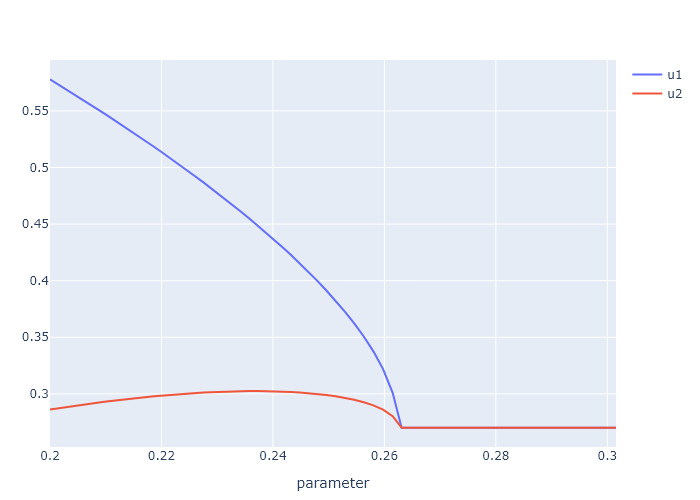

In [216]:
# Create trace
u1 = scatter(
    x = new_par_values,
    y = conditions[:,1],
    mode="lines",
    name="u1",
    showlegend=true
    )
u2 = scatter(
    x = new_par_values,
    y = conditions[:,2],
    mode="lines",
    name="u2",
    showlegend=true
    )

layout = Layout(
    xaxis_title = "parameter",
    # yaxis_type="log",
    yaxis_exponentformat="power",
    # yaxis_title = "",
    width=700, height=350,
    )

plot([u1, u2], layout)

In [220]:
find_limit_cycle(hopf2d_modified, [1 1], 6, phase_index = 0)

([1.272019642438688 5.125409141395162e-8], 6.283185307699369)

In [205]:
size(conditions)[1]

199